### Where does the dataset come from? Download from yelp.com

### Businesses

In [18]:
import pandas as pd
import json
import re
import numpy as np

In [3]:
data = []

with open('yelp_dataset/yelp_academic_dataset_business.json') as f:

    for line in f:
        
        json_dict = json.loads(line)

        if json_dict['attributes']:
            if 'BusinessParking' in json_dict['attributes'].keys():

                json_dict['attributes']['BusinessParking'] = eval(json_dict['attributes']['BusinessParking'])

        data.append(json_dict)

In [4]:
businesses = pd.json_normalize(data)

In [5]:
businesses.columns = businesses.columns.str.split(('.')).str[-1]

In [6]:
businesses.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'categories', 'hours', 'ByAppointmentOnly',
       'BusinessAcceptsCreditCards', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'BikeParking',
       'RestaurantsPriceRange2', 'CoatCheck', 'RestaurantsTakeOut',
       'RestaurantsDelivery', 'Caters', 'WiFi', 'garage', 'street',
       'validated', 'lot', 'valet', 'WheelchairAccessible', 'HappyHour',
       'OutdoorSeating', 'HasTV', 'RestaurantsReservations', 'DogsAllowed',
       'Sunday', 'Alcohol', 'GoodForKids', 'BusinessParking',
       'RestaurantsAttire', 'Ambience', 'RestaurantsTableService',
       'RestaurantsGoodForGroups', 'DriveThru', 'attributes', 'NoiseLevel',
       'GoodForMeal', 'BusinessAcceptsBitcoin', 'Smoking', 'Music',
       'GoodForDancing', 'AcceptsInsurance', 'BestNights', 'BYOB', 'Corkage',
       'BYOBCorkage', 'HairSpecializesIn', 'O

In [7]:
columns = []

for column in businesses.columns:
    column = re.sub(r'(\w)([A-Z])', r'\1_\2', column)
    column = re.sub(r'Restaurants_', r'', column)
    column = re.sub(r'Business_', r'', column)
    column = re.sub(r'(Range)([0-9])', r'\1', column)
    columns.append(column.lower())

businesses.columns = columns

In [8]:
businesses.drop(
  [
    'attributes',
    'hair_specializes_in',
    'counter_service',
    'open24_hours',
    'dietary_restrictions',
    'accepts_insurance',
    'ages_allowed',
    'b_yo_bcorkage',
    'corkage',
    'smoking',
    'b_yo_b',
    'good_for_dancing',
    'coat_check',
    'by_appointment_only',
    'best_nights',
    'music',
    'drive_thru',
    'accepts_bitcoin',
    'dogs_allowed',
    'happy_hour',
    'wheelchair_accessible',
    'good_for_meal',
    'ambience',
    'business_parking',
    'address',
    'postal_code',
    'hours',
    'is_open',
    'monday',
    'tuesday',
    'wednesday',
    'thursday',
    'friday',
    'saturday',
    'sunday'
  ],
  axis=1, errors='ignore', inplace=True
)

In [9]:
businesses['alcohol'] = businesses['alcohol'].str.replace("u'", "").str.replace("'", "")
businesses['noise_level'] = businesses['noise_level'].str.replace("u'", "").str.replace("'", "")
businesses['attire'] = businesses['attire'].str.replace("u'", "").str.replace("'", "")
businesses['wi_fi'] = businesses['wi_fi'].str.replace("u'", "").str.replace("'", "")

In [10]:
def check_parking(row):
    if row['garage'] == True or row['street'] == True or row['validated'] == True or row['lot'] == True or row['valet'] == True:
        return 'True'
    if row['garage'] == False or row['street'] == False or row['validated'] == False or row['lot'] == False or row['valet'] == False:
        return 'False'
    else:
        return np.nan

In [11]:
businesses['parking_available'] = businesses.apply(check_parking, axis=1)

In [12]:
businesses.drop(['garage', 'street','validated','lot','valet'], axis=1, inplace=True)

In [13]:
businesses.columns

Index(['business_id', 'name', 'city', 'state', 'latitude', 'longitude',
       'stars', 'review_count', 'categories', 'accepts_credit_cards',
       'bike_parking', 'price_range', 'take_out', 'delivery', 'caters',
       'wi_fi', 'outdoor_seating', 'has_tv', 'reservations', 'alcohol',
       'good_for_kids', 'parking', 'attire', 'table_service',
       'good_for_groups', 'noise_level', 'parking_available'],
      dtype='object')

### We have created a table with all businesses and the attributes we want to have a look at

### Businesses in Pennsylvania

In [14]:
pennsylvania = businesses[businesses['state'] == 'PA'].copy()

### Restaurants in Pennsylvania

In [15]:
pennsylvania.dropna(subset='categories', inplace=True)
pennsylvania.reset_index(drop=True, inplace=True)

In [16]:
# Is there a faster ways to do this?

categories =[
    'Coffee & Tea',
    'Bistros',
    'Breakfast & Brunch',
    'Cafes',
    'French',
    'Greek',
    'Italian',
    'Mexican',
    'Tacos',
    'Egyptian',
    'Pizza',
    'Soup',
    'Sushi Bars',
    'Vegetarian',
    'Waffles',
    'Food',
    'Restaurants',
    'Bars'
]

restaurants = pd.DataFrame()

for index, item in pennsylvania['categories'].items():

    for category in categories:
        if category in item:
            restaurants = pd.concat([restaurants, pennsylvania[index:index+1]])
            break

In [17]:
with open('tables/restaurants_pennsylvania.csv', 'w') as f:
    restaurants.to_csv(f, mode='a', header=True, index=False)

### We have created a table with all restaurants in Pennsylvania and saved it in a .csv for later analysis

### Now we load the table with all reviews and create a .csv which only contains reviews from restaurants in Pennsylvania

In [18]:
businesses_ids = restaurants['business_id'].to_list()

column_names = ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']

chunks = pd.read_json('yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=100000)

with open('tables/reviews_pennsylvania.csv', 'w') as f:
    header = ','.join(column_names)
    f.write(header + '\n')

    for chunk in chunks:
        reviews = pd.DataFrame(chunk)
        
        reviews[reviews['business_id'].isin(businesses_ids)].to_csv(f, mode='a', header=False, index=False)

In [8]:
import sys

modulename = 'pandas'
if modulename not in sys.modules:
    print('You have not imported the {} module'.format(modulename))

You have not imported the pandas module


### Analysis starts here

In [15]:
while True:
    user_input = input(
         '''
            Do you want to load restaurants_pennsylvania.csv?
            Press 1 to load the file, 
            press 2 to terminate without loading the file
            '''
    )

    try:
        user_input = int(user_input)

        if user_input == 1:
            print('Loading the file...')
            
            import sys
            modulename = 'pandas'
            if modulename not in sys.modules:
                import pandas as pd

            restaurants = pd.read_csv('tables/restaurants_pennsylvania.csv')
            break

        elif user_input == 2:
            print('Terminated without loading the file...')
            break

        else:
            print('Invalid input. Please enter either 1 or 2')

    except ValueError:
        print('Invalid input. Please enter either 1 or 2')


Loading the file...


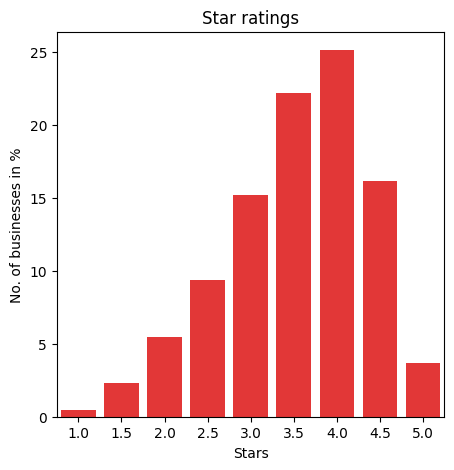

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5, 5))

# fig.suptitle('Customer ratings', fontsize=16)

sns.barplot(
    ax = ax,
    x=restaurants['stars'].value_counts().sort_index().index,
    y=restaurants['stars'].value_counts().sort_index().values*100/restaurants['stars'].value_counts().sort_index().values.sum(),
    color='#FF1A1A'
)
ax.set(xlabel='Stars', ylabel='No. of businesses in %')
ax.set_title('Star ratings');

In [19]:
# Replace values in columns by dummies

columns = []
stop_list = [
    'business_id',
    'name',
    'city',
    'state',
    'latitude',
    'longitude',
    'stars',
    'review_count',
    'categories',
    'monday',
    'tuesday',
    'wednesday',
    'thursday',
    'friday',
    'saturday',
    'sunday'
]

for column in restaurants.columns:
    if column not in stop_list:  
        columns.append(column)

for column in columns:
    restaurants[column].replace('True', 1, inplace=True)
    restaurants[column].replace('False', 0, inplace=True)
    restaurants[column].replace('nan', np.NaN, inplace=True)
    restaurants[column].replace('None', np.NaN, inplace=True)
    restaurants[column].replace('none', np.NaN, inplace=True)
    restaurants[column].replace('casual', 0, inplace=True)
    restaurants[column].replace('formal', 1, inplace=True)
    restaurants[column].replace('dressy', 2, inplace=True)
    restaurants[column].replace('full_bar', 0, inplace=True)
    restaurants[column].replace('beer_and_wine', 1, inplace=True)
    restaurants[column].replace('average', 0, inplace=True)
    restaurants[column].replace('quiet', 1, inplace=True)
    restaurants[column].replace('loud', 2, inplace=True)
    restaurants[column].replace('very_loud', 3, inplace=True)
    restaurants[column].replace('no', 0, inplace=True)
    restaurants[column].replace('free', 1, inplace=True)
    restaurants[column].replace('paid', 2, inplace=True)

In [20]:
restaurants[[
    'stars',
    'accepts_credit_cards',
    'bike_parking',
    'price_range',
    'take_out',
    'delivery',
    'caters',
    'wi_fi',
    'outdoor_seating',
    'has_tv',
    'reservations',
    'alcohol',
    'good_for_kids',
    'attire',
    'table_service',
    'good_for_groups',
    'noise_level',
    'parking_available'
]].corr(method='spearman')

,stars,accepts_credit_cards,bike_parking,price_range,take_out,delivery,caters,wi_fi,outdoor_seating,has_tv,reservations,alcohol,good_for_kids,attire,table_service,good_for_groups,noise_level,parking_available
stars,1.000000,-0.130977,0.137589,0.036941,0.051961,-0.070302,0.091434,0.011965,0.129522,-0.158019,0.070032,0.116523,0.017891,0.014081,0.010446,-0.009656,-0.102435,0.119663
accepts_credit_cards,-0.130977,1.000000,0.002617,0.133249,0.020213,0.154619,0.128099,0.149108,0.053959,0.019394,0.116499,0.017968,0.009395,0.016988,0.024261,0.114183,0.009832,0.028142
bike_parking,0.137589,0.002617,1.000000,0.012484,0.034815,0.002205,0.052729,0.047448,0.182129,-0.036851,0.040183,0.055296,-0.011401,-0.045705,0.028873,0.048105,-0.047360,0.128385
price_range,0.036941,0.133249,0.012484,1.000000,-0.133031,-0.135222,0.036171,0.063369,0.166577,-0.086793,0.516180,-0.214469,-0.276821,0.220382,0.440586,0.184954,-0.069073,0.136778
take_out,0.051961,0.020213,0.034815,-0.133031,1.000000,0.164228,0.185881,0.025149,0.004491,0.048280,-0.093890,0.065703,0.259302,-0.200256,-0.018019,-0.044866,-0.056146,-0.002124
delivery,-0.070302,0.154619,0.002205,-0.135222,0.164228,1.000000,0.206868,0.081091,-0.011468,0.128195,-0.096798,0.120396,0.183249,-0.099113,-0.061759,-0.032573,-0.023570,-0.022297
caters,0.091434,0.128099,0.052729,0.036171,0.185881,0.206868,1.000000,0.130688,0.088330,-0.011817,0.084898,0.042844,0.178745,-0.027496,-0.020379,0.050184,-0.040190,0.054545
wi_fi,0.011965,0.149108,0.047448,0.063369,0.025149,0.081091,0.130688,1.000000,0.209712,0.069919,0.110230,-0.077417,0.000844,0.024849,0.111557,0.171167,-0.054308,0.052776
outdoor_seating,0.129522,0.053959,0.182129,0.166577,0.004491,-0.011468,0.088330,0.209712,1.000000,-0.028051,0.163593,-0.115186,-0.138018,0.015832,0.110636,0.097857,-0.109079,0.158188
has_tv,-0.158019,0.019394,-0.036851,-0.086793,0.048280,0.128195,-0.011817,0.069919,-0.028051,1.000000,-0.038081,-0.133123,0.017301,-0.013436,0.131014,0.064851,-0.023177,-0.092220


In [30]:
while True:
    user_input = input(
         '''
            Do you want to load reviews_pennsylvania.csv?
            Press 1 to load the file, 
            press 2 to terminate without loading the file
            '''
    )

    try:
        user_input = int(user_input)

        if user_input == 1:
            print('Loading the file...')
            
            import sys
            modulename = 'pandas'
            if modulename not in sys.modules:
                import pandas as pd

            reviews = pd.read_csv('tables/reviews_pennsylvania.csv')
            break

        elif user_input == 2:
            print('Terminated without loading the file...')
            break

        else:
            print('Invalid input. Please enter either 1 or 2')

    except ValueError:
        print('Invalid in^put. Please enter either 1 or 2')

Loading the file...


In [31]:
reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
2,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
3,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
4,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14
...,...,...,...,...,...,...,...,...,...
1205557,MVg4YUQeEhCA7Z7RsBJSVg,7-7A0Avj47slLGV7yBFc8w,ytynqOUb3hjKeJfRj5Tshw,3,1,0,0,"I was so excited about all the food I saw, but...",2013-07-25 21:00:15
1205558,nLjbVsETpqO17RbFcqskkA,am7-gkH_PDz598oTdYSD6A,3gVSrS4kffGGZT8oXHsIcw,3,2,0,2,"*Later Yelp* I've only been here once, but I l...",2014-11-03 14:45:46
1205559,KlHxcAifUF5zDKpJCBrRsw,7ziWZULyiZv2TesYNMFf4g,qQO7ErS_RAN4Vs1uX0L55Q,4,1,0,0,"ice cream! ice cream sodas, sundaes!! \n\nwant...",2012-10-21 04:08:40
1205560,cACxcUY_AIsQKkpDRXuqnw,MCzlzlOw7IGbRAKVjJBPtg,fcGexL5VH5G2Xw0tRj9uOQ,3,1,1,0,This is a good pizza option - they deliver thr...,2018-03-13 13:54:48


In [42]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_md')
nlp.add_pipe('spacytextblob')

def check_polarity(text):
    doc = nlp(text)
    return doc._.blob.polarity

reviews['polarity'] = reviews['text'][:100].apply(lambda x: check_polarity(x))